# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Setup

In [3]:
# checkpoint_callback = ModelCheckpoint(
#     filepath='/content/gdrive/MyDrive/Colab Notebooks/best_model.keras',
#     monitor='val_accuracy',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='max',
#     verbose=1
# )

In [4]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # đảm bảo hash ngẫu nhiên của Python cũng được kiểm soát
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

seed_everything()

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-06-24 14:36:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-24 14:36:28 (84.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [6]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
import kagglehub

path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals10


# EDA & Preprocessing

In [7]:
dataset = "/kaggle/input/animals10/raw-img"
walk_through_dir(dataset)

There are 10 directories and 0 images in '/kaggle/input/animals10/raw-img'.
There are 0 directories and 2623 images in '/kaggle/input/animals10/raw-img/cavallo'.
There are 0 directories and 1820 images in '/kaggle/input/animals10/raw-img/pecora'.
There are 0 directories and 1446 images in '/kaggle/input/animals10/raw-img/elefante'.
There are 0 directories and 1668 images in '/kaggle/input/animals10/raw-img/gatto'.
There are 0 directories and 1862 images in '/kaggle/input/animals10/raw-img/scoiattolo'.
There are 0 directories and 3098 images in '/kaggle/input/animals10/raw-img/gallina'.
There are 0 directories and 4821 images in '/kaggle/input/animals10/raw-img/ragno'.
There are 0 directories and 1866 images in '/kaggle/input/animals10/raw-img/mucca'.
There are 0 directories and 4863 images in '/kaggle/input/animals10/raw-img/cane'.
There are 0 directories and 2112 images in '/kaggle/input/animals10/raw-img/farfalla'.


In [8]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    filepaths = []
    extensions = ['jpg', 'jpeg', 'png','JPG','PNG']
    for ext in extensions:
        filepaths.extend(image_dir.glob(f'**/*.{ext.lower()}'))
        filepaths.extend(image_dir.glob(f'**/*.{ext.upper()}'))

    labels = list(map(lambda x: x.parent.name, filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')


    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

/tmp/ipython-input-9-2237132461.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
/tmp/ipython-input-9-2237132461.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


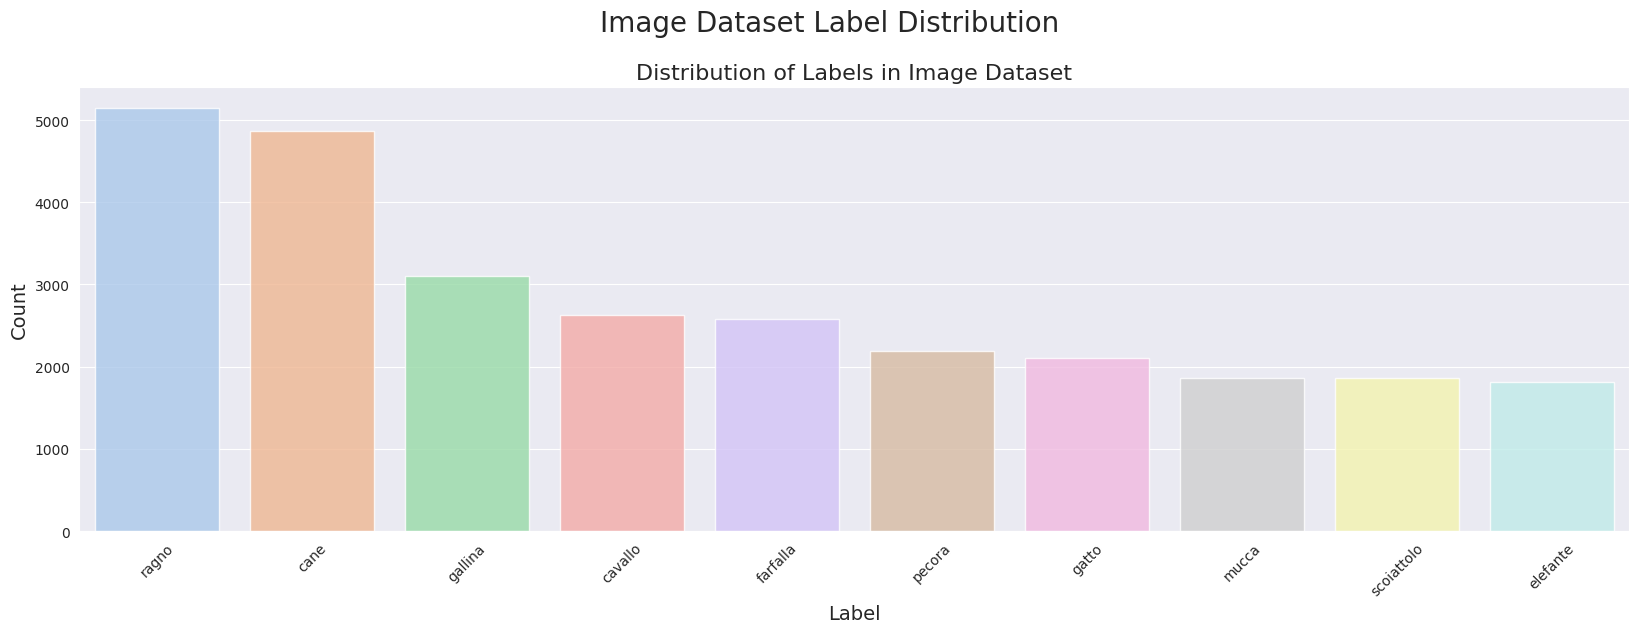

In [9]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
# làm sạch dữ liệu
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

# Get the value counts for each label
label_counts = image_df['Label'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)
fig.suptitle('Image Dataset Label Distribution', fontsize=20)
fig.subplots_adjust(top=0.85)
plt.show()

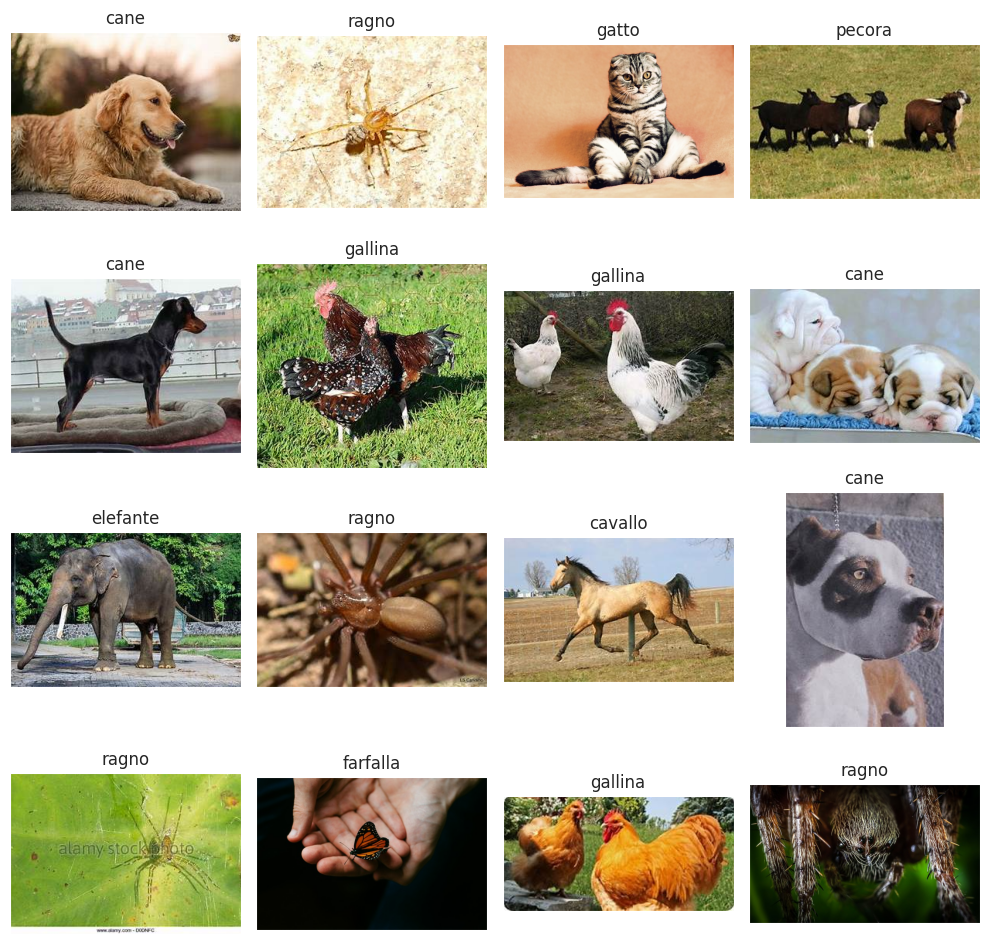

In [10]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [11]:
def random_sample(directory, exts=('.jpg', '.jpeg', '.png', '.JPG')):
    files = [f for f in os.listdir(directory) if f.endswith(exts)]
    if not files:
        raise ValueError(f"No image files found in {directory}")
    return os.path.join(directory, random.choice(files))


def compute_ela_cv(path, quality=90, scale=15):
  """
  Tính ảnh Error Level Analysis (ELA) từ ảnh đầu vào.

  Parameters:
      path (str): Đường dẫn ảnh gốc.
      quality (int): Mức chất lượng JPEG (0–100), càng thấp càng nén mạnh.
      scale (int): Hệ số phóng đại độ chênh lệch (giúp thấy rõ sai khác).

  Returns:
      np.array: Ảnh ELA dưới dạng mảng NumPy.
  """
  # Bước 1: Đọc ảnh gốc
  original = cv2.imread(path)
  if original is None:
      raise FileNotFoundError(f"Could not load image at path: {path}")

  # Bước 2: Lưu ảnh tạm dưới dạng JPEG nén lại
  temp_filename = 'temp_ela.jpg'
  cv2.imwrite(temp_filename, original, [cv2.IMWRITE_JPEG_QUALITY, quality])

  # Bước 3: Đọc lại ảnh nén
  compressed = cv2.imread(temp_filename)

  # Bước 4: Tính độ chênh lệch tuyệt đối giữa ảnh gốc và ảnh nén
  diff = cv2.absdiff(original, compressed)

  # Bước 5: Phóng đại sai khác để dễ quan sát
  ela_image = np.clip(diff * scale, 0, 255).astype(np.uint8)

  # Chuyển từ BGR sang RGB để matplotlib hiển thị đúng màu
  ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2RGB)

  return ela_image

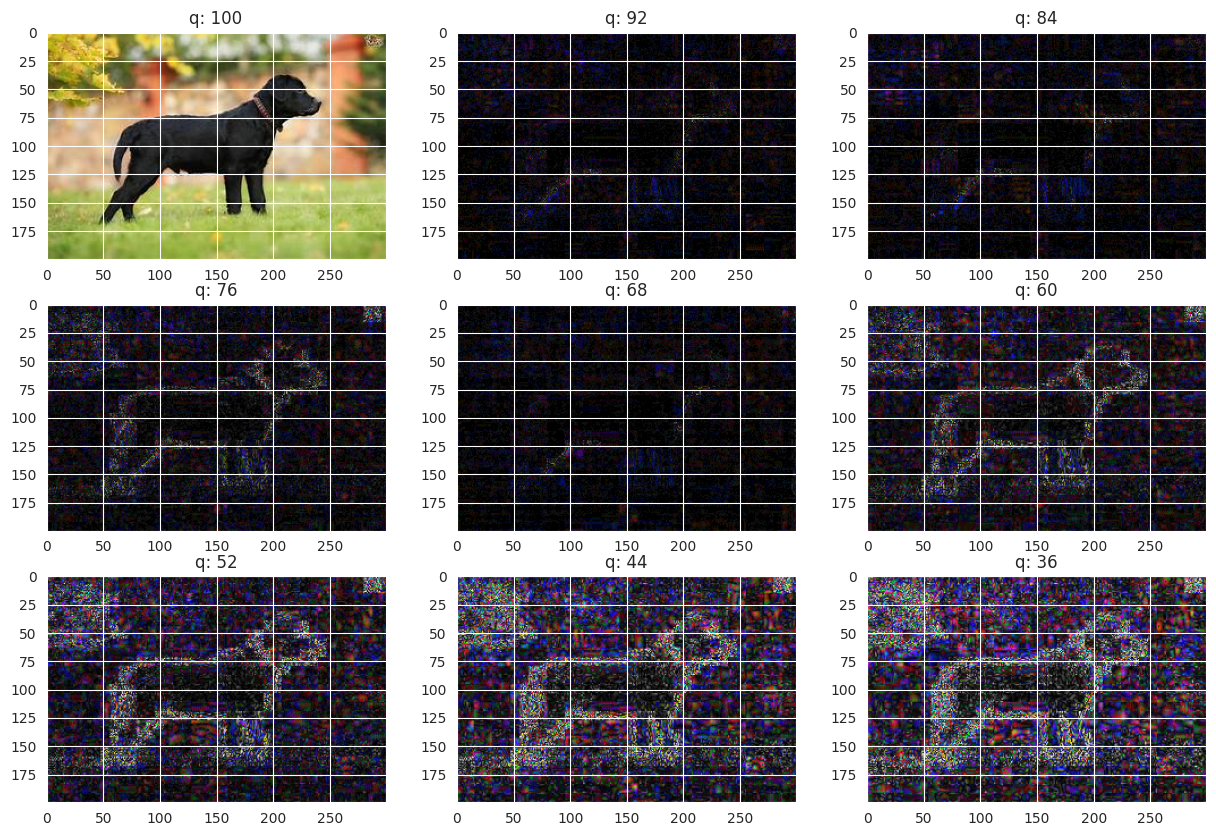

In [12]:
# View random sample from the dataset
p = random_sample('/kaggle/input/animals10/raw-img/cane')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Modeling

# CNN EfficientNetB0

In [13]:
# callback TensorBoard để lưu logs của một lần chạy huấn luyện
import datetime
import os
from tensorflow.keras.callbacks import TensorBoard

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = TensorBoard(log_dir=log_dir)
  print(f"Đang lưu logs của TensorBoard vào: {log_dir}")
  return tensorboard_callback

In [ ]:
# ==============================================================================
# PHẦN 0: IMPORTS VÀ CÀI ĐẶT BAN ĐẦU
# ==============================================================================
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Các import cần thiết cho việc xây dựng và huấn luyện mô hình
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing import image


# ==============================================================================
# PHẦN 1: CÁC HÀM TIỀN XỬ LÝ VÀ CHUẨN BỊ DỮ LIỆU
# ==============================================================================

# --- Pipeline cho các mô hình DEEP LEARNING (EfficientNet, ResNet) ---
def create_dl_pipeline(df, class_names, image_size, batch_size, model_preprocessor, use_augmentation=False):
    filepaths = df['Filepath'].values
    labels = pd.get_dummies(df['Label'])[class_names].values

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    AUTOTUNE = tf.data.AUTOTUNE

    augment = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2)
    ])

    def load_and_resize(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, image_size)
        return img, label

    dataset = dataset.map(load_and_resize, num_parallel_calls=AUTOTUNE)

    if use_augmentation:
        dataset = dataset.map(lambda img, lbl: (augment(img), lbl), num_parallel_calls=AUTOTUNE)

    dataset = dataset.map(lambda img, lbl: (model_preprocessor(img), lbl), num_parallel_calls=AUTOTUNE)

    if use_augmentation:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return dataset

# --- Pipeline cho các mô hình ML CỔ ĐIỂN (SVM, Random Forest) ---
def extract_features_for_ml(df, feature_extractor, image_size, model_preprocessor):
    filepaths = df['Filepath'].values

    features = []
    print(f"Đang trích xuất {len(filepaths)} đặc trưng...")

    for path in tqdm(filepaths):
        img = image.load_img(path, target_size=image_size)
        img_array = image.img_to_array(img)
        img_expanded = np.expand_dims(img_array, axis=0)
        img_preprocessed = model_preprocessor(img_expanded)
        feature_vector = feature_extractor.predict(img_preprocessed, verbose=0)
        features.append(feature_vector.flatten())

    le = LabelEncoder()
    labels_encoded = le.fit_transform(df['Label'])

    return np.array(features), labels_encoded, le


# ==============================================================================
# PHẦN 2: TẢI, PHÂN CHIA DỮ LIỆU VÀ ĐỊNH NGHĨA CÁC THAM SỐ
# ==============================================================================

# Phân chia dữ liệu
train_val_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42, stratify=image_df['Label'])
train_df, val_df = train_test_split(train_val_df, test_size=0.2, shuffle=True, random_state=42, stratify=train_val_df['Label'])

print(f"Tổng số ảnh: {len(image_df)}")
print(f"Số lượng ảnh trong tập huấn luyện: {len(train_df)}")
print(f"Số lượng ảnh trong tập validation: {len(val_df)}")
print(f"Số lượng ảnh trong tập kiểm thử: {len(test_df)}")

# Định nghĩa các tham số chung
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CLASS_NAMES = sorted(train_df['Label'].unique())
print(f"\nCác lớp được phát hiện: {CLASS_NAMES}")


# ==============================================================================
# BẮT ĐẦU HUẤN LUYỆN - CHỌN 1 TRONG 2 LỰA CHỌN DƯỚI ĐÂY
# ==============================================================================

### LỰA CHỌN 1: HUẤN LUYỆN MÔ HÌNH DEEP LEARNING (EFFICIENTNET) ###
# --------------------------------------------------------------------
print("\n--- BẮT ĐẦU LỰA CHỌN 1: HUẤN LUYỆN EFFICIENTNET ---")

# A. Chuẩn bị dữ liệu bằng pipeline DL
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocessor
train_ds = create_dl_pipeline(train_df, CLASS_NAMES, IMAGE_SIZE, BATCH_SIZE, efficientnet_preprocessor, use_augmentation=True)
val_ds = create_dl_pipeline(val_df, CLASS_NAMES, IMAGE_SIZE, BATCH_SIZE, efficientnet_preprocessor)
test_ds = create_dl_pipeline(test_df, CLASS_NAMES, IMAGE_SIZE, BATCH_SIZE, efficientnet_preprocessor)

# B. Xây dựng mô hình
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SIZE, 3),
    pooling='max'
)
pretrained_model.trainable = False

# Định nghĩa Callbacks
checkpoint_path = "efficientnetb0_best_model.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      monitor="val_accuracy",
                                      save_best_only=True,
                                      save_weights_only=True, # Chỉ lưu trọng số là đủ
                                      mode='max',
                                      verbose=1)

early_stopping = EarlyStopping(monitor="val_loss",
                             patience=10, # Tăng patience một chút
                             restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=5, # Giảm LR nếu val_loss không cải thiện sau 5 epochs
                            min_lr=1e-6)

# Xây dựng mô hình hoàn chỉnh
inputs = layers.Input(shape=(*IMAGE_SIZE, 3), name="input_layer")
x = pretrained_model(inputs, training=False)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation='softmax', name="output_layer")(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# C. Huấn luyện mô hình
# !! GHI CHÚ: Bỏ comment dòng dưới đây để bắt đầu huấn luyện.
# Quá trình này có thể mất nhiều thời gian.
#
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        checkpoint_callback,
        early_stopping,
        reduce_lr,
        create_tensorboard_callback("training_logs", "efficientnet_b0_transfer_learning")
    ]
)

print("\nĐánh giá trên tập test sau khi huấn luyện:")
model.load_weights(checkpoint_path) # Tải lại trọng số tốt nhất
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# ##############################################################################
# ### LỰA CHỌN 2: HUẤN LUYỆN MÔ HÌNH ML CỔ ĐIỂN (RANDOM FOREST) ###
# # --------------------------------------------------------------------
# # !! GHI CHÚ: Để chạy phần này, bạn nên comment out phần model.fit() của Lựa chọn 1
# print("\n--- BẮT ĐẦU LỰA CHỌN 2: HUẤN LUYỆN RANDOM FOREST ---")

# # A. Chuẩn bị dữ liệu bằng cách trích xuất đặc trưng
# # Dùng chính EfficientNetB0 làm công cụ trích xuất đặc trưng, pooling='avg' thường tốt hơn
# feature_extractor = tf.keras.applications.EfficientNetB0(
#     include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3), pooling='avg'
# )
# # Lấy hàm tiền xử lý tương ứng
# from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocessor_for_ml

# # Trích xuất đặc trưng cho tập train và test
# X_train_features, y_train_encoded, le = extract_features_for_ml(
#     train_df, feature_extractor, IMAGE_SIZE, efficientnet_preprocessor_for_ml
# )
# X_test_features, y_test_encoded, _ = extract_features_for_ml(
#     test_df, feature_extractor, IMAGE_SIZE, efficientnet_preprocessor_for_ml
# )

# print(f"\nKích thước ma trận đặc trưng tập train: {X_train_features.shape}")
# print(f"Kích thước ma trận đặc trưng tập test: {X_test_features.shape}")

# # B. Xây dựng và Huấn luyện mô hình Random Forest
# print("\nĐang huấn luyện mô hình Random Forest...")
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, verbose=1)
# rf_model.fit(X_train_features, y_train_encoded)

# # C. Đánh giá mô hình
# y_pred = rf_model.predict(X_test_features)
# accuracy_rf = accuracy_score(y_test_encoded, y_pred)
# print(f"\nĐỘ CHÍNH XÁC CỦA RANDOM FOREST TRÊN TẬP TEST: {accuracy_rf:.4f}")

# print("\nBáo cáo phân loại chi tiết:")
# print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

Tổng số ảnh: 28149
Số lượng ảnh trong tập huấn luyện: 18015
Số lượng ảnh trong tập validation: 4504
Số lượng ảnh trong tập kiểm thử: 5630

Các lớp được phát hiện: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

--- BẮT ĐẦU LỰA CHỌN 1: HUẤN LUYỆN EFFICIENTNET ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,250,669 (16.22 MB)

 Trainable params: 200,330 (782.54 KB)

 Non-trainable params: 4,050,339 (15.45 MB)

Đang lưu logs của TensorBoard vào: training_logs/efficientnet_b0_transfer_learning/20250624-143702
Epoch 1/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.3842 - loss: 2.1370
Epoch 1: val_accuracy improved from -inf to 0.94605, saving model to efficientnetb0_best_model.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 301s 466ms/step - accuracy: 0.3845 - loss: 2.1359 - val_accuracy: 0.9460 - val_loss: 0.2071 - learning_rate: 1.0000e-04
Epoch 2/100
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7662 - loss: 0.7538
Epoch 2: val_accuracy improved from 0.94605 to 0.96181, saving model to efficientnetb0_best_model.weights.h5
563/563 ━━━━━━━━━━━━━━━━━━━━ 232s 392ms/step - accuracy: 0.7662 - loss: 0.7536 - val_accuracy: 0.9618 - val_loss: 0.1328 - learning_rate: 1.0000e-04
Epoch 3/100
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8292 - loss: 0.5517
Epoch 3: val_accuracy improved from 0.96181 to 0.96825, saving model to efficientnetb0_best_model.weights.h5
563/563 ━━━━

In [ ]:
# # ==============================================================================
# # BƯỚC 1: CHUẨN BỊ DỮ LIỆU (Thay thế hoàn toàn ImageDataGenerator)
# # ==============================================================================

# # 1.1 Phân chia dữ liệu một cách tường minh thành 3 tập
# # Sử dụng stratify để đảm bảo phân bố nhãn đồng đều
# train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42, stratify=image_df['Label'])
# train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42, stratify=train_df['Label'])

# print(f"Số lượng ảnh trong tập huấn luyện: {len(train_df)}")
# print(f"Số lượng ảnh trong tập validation: {len(val_df)}")
# print(f"Số lượng ảnh trong tập kiểm thử: {len(test_df)}")

# # 1.2 Chuẩn bị Filepaths và Labels ở dạng One-Hot
# train_filepaths = train_df['Filepath'].values
# val_filepaths = val_df['Filepath'].values
# test_filepaths = test_df['Filepath'].values

# train_labels = pd.get_dummies(train_df['Label']).values
# val_labels = pd.get_dummies(val_df['Label']).values
# test_labels = pd.get_dummies(test_df['Label']).values
# class_names = pd.get_dummies(train_df['Label']).columns.tolist() # Lấy tên các lớp

# # 1.3 Xây dựng các hàm tiền xử lý và tăng cường dữ liệu
# AUTOTUNE = tf.data.AUTOTUNE

# # Định nghĩa lớp tăng cường dữ liệu
# augment = tf.keras.Sequential([
#   # Lưu ý: Không cần Resizing và Rescaling ở đây nữa vì nó đã được xử lý trong hàm map
#   layers.RandomFlip("horizontal"),
#   layers.RandomRotation(0.2), # Tăng giá trị một chút để augmentation mạnh hơn
#   layers.RandomZoom(0.2),
#   layers.RandomContrast(0.2),
# ])

# def load_and_preprocess_image(path, label):
#     image = tf.io.read_file(path)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(image, TARGET_SIZE)
#     # Không cần preprocess_input của EfficientNet ở đây, sẽ áp dụng sau
#     return image, label

# def apply_augmentation_and_preprocessing(image, label):
#     # Áp dụng augmentation chỉ cho tập huấn luyện
#     image = augment(image)
#     # Áp dụng tiền xử lý của EfficientNet
#     image = tf.keras.applications.efficientnet.preprocess_input(image)
#     return image, label

# # 1.4 Tạo các đường ống tf.data
# # Tập Huấn luyện (có augmentation)
# train_ds = tf.data.Dataset.from_tensor_slices((train_filepaths, train_labels))
# train_ds = (
#     train_ds
#     .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
#     .shuffle(buffer_size=1000)
#     .map(apply_augmentation_and_preprocessing, num_parallel_calls=AUTOTUNE) # Augmentation sau khi shuffle
#     .batch(BATCH_SIZE)
#     .prefetch(buffer_size=AUTOTUNE)
# )

# # Tập Validation (không có augmentation)
# val_ds = tf.data.Dataset.from_tensor_slices((val_filepaths, val_labels))
# val_ds = (
#     val_ds
#     .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
#     .batch(BATCH_SIZE)
#     .map(lambda image, label: (tf.keras.applications.efficientnet.preprocess_input(image), label)) # Chỉ tiền xử lý
#     .prefetch(buffer_size=AUTOTUNE)
# )

# # Tập Test (không có augmentation)
# test_ds = tf.data.Dataset.from_tensor_slices((test_filepaths, test_labels))
# test_ds = (
#     test_ds
#     .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
#     .batch(BATCH_SIZE)
#     .map(lambda image, label: (tf.keras.applications.efficientnet.preprocess_input(image), label)) # Chỉ tiền xử lý
#     .prefetch(buffer_size=AUTOTUNE)
# )

# # ==============================================================================
# # BƯỚC 2: XÂY DỰNG VÀ HUẤN LUYỆN MÔ HÌNH (Sửa lại cách xây dựng)
# # ==============================================================================

# # 2.1 Tải mô hình nền
# # KHUYẾN NGHỊ: Đổi sang B0 để train nhanh hơn, kết quả vẫn rất tốt
# pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3),
#     pooling='max' # Giữ lại pooling='max' là một lựa chọn tốt
# )
# pretrained_model.trainable = False # Đóng băng mô hình nền

# # 2.2 Định nghĩa Callbacks (Giữ nguyên, code của bạn đã rất tốt)
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# checkpoint_path = "animals_classification_model_checkpoint.weights.h5"
# checkpoint_callback = ModelCheckpoint(checkpoint_path,
#                                       save_weights_only=True,
#                                       monitor="val_accuracy",
#                                       save_best_only=True)
# early_stopping = EarlyStopping(monitor="val_loss",
#                                patience=5,
#                                restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# # 2.3 Xây dựng mô hình hoàn chỉnh (Sửa lại cách kết nối các lớp)
# # Đây là cách tiếp cận đơn giản và đúng đắn hơn với Functional API
# inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
# # Tiền xử lý và augmentation được xử lý trong tf.data, không cần lớp augment ở đây nữa
# x = pretrained_model(inputs, training=False) # training=False quan trọng khi đóng băng
# x = Dense(128, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.45)(x)
# x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.45)(x)
# outputs = Dense(10, activation='softmax', name="output_layer")(x)

# model = Model(inputs=inputs, outputs=outputs)

# # 2.4 Biên dịch mô hình
# model.compile(
#     optimizer=Adam(learning_rate=1e-4), # Có thể tăng learning rate một chút
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary() # In ra cấu trúc mô hình để kiểm tra

# # 2.5 Huấn luyện mô hình
# # Không cần steps_per_epoch và validation_steps nữa, tf.data tự xử lý
# import gc
# del image_df, train_df, val_df, test_df
# del train_filepaths, val_filepaths, test_filepaths
# del train_labels, val_labels, test_labels
# gc.collect()
# history = model.fit(
#     train_ds,  # Dùng train_ds đã tạo
#     validation_data=val_ds, # Dùng val_ds đã tạo
#     epochs=100, # Early stopping sẽ tự dừng khi cần
#     callbacks=[
#         checkpoint_callback,
#         early_stopping,
#         create_tensorboard_callback("training_logs", "animals_classification"), # Đảm bảo hàm này tồn tại
#         checkpoint_callback,
#         reduce_lr
#     ]
# )

In [ ]:
# # ==============================================================================
# # BƯỚC 3: ĐÁNH GIÁ MÔ HÌNH SAU KHI HUẤN LUYỆN
# # ==============================================================================
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# # 3.1 Vẽ đồ thị quá trình học (Loss và Accuracy)
# # Sử dụng hàm plot_loss_curves từ file helper_functions.py
# print("--- Đồ thị quá trình học ---")
# plot_loss_curves(history)
# plt.show()

# # 3.2 Đánh giá hiệu năng cuối cùng trên tập Test
# print("\n--- Đánh giá trên tập dữ liệu Test ---")
# loss, accuracy = model.evaluate(test_ds)
# print(f"Loss trên tập Test: {loss:.4f}")
# print(f"Accuracy trên tập Test: {accuracy*100:.2f}%")

# # 3.3 Lấy dự đoán và nhãn thật để phân tích sâu hơn
# print("\n--- Đang tạo dự đoán trên tập Test để phân tích... ---")
# # Lấy dự đoán dưới dạng xác suất
# y_pred_probs = model.predict(test_ds, verbose=1)

# # Chuyển từ xác suất sang nhãn dự đoán (lấy index của giá trị lớn nhất)
# y_pred = y_pred_probs.argmax(axis=1)

# # Lấy nhãn thật từ test_ds
# # Cần duyệt qua dataset để lấy tất cả các nhãn
# y_true = []
# for images, labels in test_ds:
#   y_true.extend(labels.numpy().argmax(axis=1))
# y_true = np.array(y_true)

# # 3.4 In báo cáo phân loại (Classification Report)
# print("\n--- Báo cáo phân loại chi tiết (Classification Report) ---")
# # Sử dụng class_names đã lấy ở bước chuẩn bị dữ liệu
# print(classification_report(y_true, y_pred, target_names=class_names))

# # 3.5 Vẽ Ma trận nhầm lẫn (Confusion Matrix)
# print("\n--- Ma trận nhầm lẫn (Confusion Matrix) ---")
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# # Vẽ ma trận
# fig, ax = plt.subplots(figsize=(12, 12))
# disp.plot(ax=ax, cmap=plt.cm.Blues)
# plt.title("Ma trận nhầm lẫn")
# plt.xticks(rotation=45)
# plt.show()